In [39]:
import qiskit
import qiskit_aer
from qiskit_aer import AerSimulator
import numpy as np

In [40]:
def evolve_basic(g, dt, N):
    
    circ = qiskit.QuantumCircuit(N)
    
    x_angle = - dt * g

    z_angle = - dt
    
    
    #e^B
    for i in range(int(N/2-1)):
        circ.rzz(z_angle, 2*i+1, 2*i+2) # x rotation
        
    for i in range(int(N/2)):
        circ.rzz(z_angle, 2*i, 2*i+1) # x rotation
           
    #e^A        
    for i in range(N):
        circ.rx(x_angle, i) # x rotation
    
    return circ

In [41]:
def evolve_symmetric(g, dt, N):
    
    circ = qiskit.QuantumCircuit(N)
    
    x_angle = - dt * g

    z_angle = - dt
    
    for i in range(N):
        
        circ.rx(x_angle/2, i) # x rotation
        
        
    for i in range(int(N/2-1)):
        
        circ.rzz(z_angle, 2*i+1, 2*i+2) # x rotation
        
    for i in range(int(N/2)):
        
        circ.rzz(z_angle, 2*i, 2*i+1) # x rotation
        
    for i in range(N):
        
        circ.rx(x_angle/2, i) # x rotation

    return circ

In [42]:
import numpy as np

# define basic Pauli matrices
s_alpha = [np.array([[1, 0], [0, 1]], dtype='complex'),
           np.array([[0, 1], [1, 0]], dtype='complex'),
           np.array([[0, -1j], [1j, 0]],dtype='complex'),
           np.array([[1, 0], [0, -1]], dtype='complex')]


# define the many-body spin operators
def sp(alpha, n, N):
    Sa = s_alpha[alpha]
    for i in range(n):
        Sa = np.kron(s_alpha[0], Sa)
    for j in range(n+1, N):
        Sa = np.kron(Sa, s_alpha[0])
    return Sa


def magn_exact_diagonalization(N, g, t, Npoints):
    """
    Benchmark the Trotterized circuit evolution with the exact Hamiltonian time evolution,
    obtained through exact diagonalization (only for small system sizes N!). 
    This function returns the magnetization for equally spaced timesteps between  0  and  t .
    """
    # array containing the magnetization of individual basis states
    magnetization_basis_states = -np.array( [np.sum(2*np.array([int(bin(n)[2:].zfill(N)[i]) for i in range(N)]) - 1.0)/N for n in range(2**N)] )

    # create the hamiltonian
    hamiltonian = np.zeros((2**N, 2**N), dtype='complex')
    for i in range(N):
        hamiltonian += g/2*sp(1, i, N)
        if i != N-1:
            hamiltonian += -1/2*sp(3, i, N) @ sp(3, i+1, N)

    # diagonalize
    E, V = np.linalg.eig(hamiltonian)

    # time evolve
    magnetization = np.zeros(Npoints)
    initial_state = np.array([int(n==0) for n in range(2**N)])
    overlap = V.transpose().conj() @ initial_state
    for ind,T in enumerate(np.linspace(0,t,Npoints)):
        state_evolved = V @ (np.exp(-1j*T*E) * overlap)
        magnetization[ind] = np.sum(magnetization_basis_states * np.abs(state_evolved)**2)

    return magnetization


# Useful functions to verify whether a given density matrix is physical

def is_Hermitian(M, rtol = 1e-5, atol = 1e-9):
    return np.allclose(M, np.conjugate(M.T), rtol=rtol, atol=atol)

def is_positive(M, tol = 1e-7):
    s = np.linalg.eigvalsh(M)
    assert (s[0] > -tol)
    for i in range(len(s)):
      if s[i] <= 0:
         s[i] = 1e-12
    return s

N = 10
g = 2 
t = 5
dt = 0.05
array_size = int(t/dt)

In [43]:
test = magn_exact_diagonalization(N, g, t, array_size)

In [7]:
mt_smooth = np.zeros((array_size))
N = 10
Evolve_Basic = evolve_basic(g, dt, N)
for i in range(array_size):
    combined = qiskit.QuantumCircuit(N)
    for j in range(i):
        combined = combined.compose(Evolve_Basic)
    combined.save_statevector()
    sim = AerSimulator()
    result = sim.run(combined).result()
    psi = result.get_statevector()
    magnetization = 0
    psi.draw('latex')
    for j, amplitude in enumerate(psi):
        if amplitude == 0: 
            continue
        else:
            basis_state = f'{j:0{N}b}'  # binary representation of the basis state
            num_zeros = basis_state.count('0')
            magnetization += (2*num_zeros - N) * (np.abs(amplitude) ** 2)
    mt_smooth[i] = magnetization /10

/var/folders/lj/rrwpcg_53lx6mcxdcppxsdz80000gn/T/ipykernel_38209/4265064952.py:14: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  for j, amplitude in enumerate(psi):


In [8]:
mt_smooth_1 = np.zeros((array_size))
Evolve_Basic = evolve_symmetric(g, dt, N)
for i in range(array_size):
    combined = qiskit.QuantumCircuit(N)
    for j in range(i):
        combined = combined.compose(Evolve_Basic)
    combined.save_statevector()
    sim = AerSimulator()
    result = sim.run(combined).result()
    psi = result.get_statevector()
    magnetization = 0
    psi.draw('latex')
    for j, amplitude in enumerate(psi):
        if amplitude == 0: 
            continue
        else:
            basis_state = f'{j:0{N}b}'  # binary representation of the basis state
            num_zeros = basis_state.count('0')
            magnetization += (2*num_zeros - N) * (np.abs(amplitude) ** 2)
    mt_smooth_1[i] = magnetization /10

/var/folders/lj/rrwpcg_53lx6mcxdcppxsdz80000gn/T/ipykernel_38209/3422611086.py:13: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  for j, amplitude in enumerate(psi):


In [9]:
mt = np.zeros(array_size)
Evolve_Basic = evolve_basic(g, dt, N)
for i in range(array_size):
    
    combined = qiskit.QuantumCircuit(N)
    for j in range(i):
        combined = combined.compose(Evolve_Basic)
    combined.measure_all()
    sim = AerSimulator()
    shot = 20
    result = sim.run(combined, shots = shot).result().get_counts()

    total = 0

# Iterate through the dictionary items
    for binary_str, count in result.items():
        # Count the number of ones in the binary string
        num_zeros = binary_str.count('0')
        # Multiply the count of ones by the histogram count
        total += (2*num_zeros - N) * count
    mt[i] = total / shot / N

In [10]:
mt2 = np.zeros(array_size)
Evolve_Sym = evolve_symmetric(g, dt, N)
for i in range(array_size):
    
    combined = qiskit.QuantumCircuit(N)
    for j in range(i):
        combined = combined.compose(Evolve_Sym)
    combined.measure_all()
    sim = AerSimulator()
    shot = 100
    result = sim.run(combined, shots = shot).result().get_counts()

    total = 0

# Iterate through the dictionary items
    for binary_str, count in result.items():
        # Count the number of ones in the binary string
        num_zeros = binary_str.count('0')
        # Multiply the count of ones by the histogram count
        total += (2*num_zeros - N) * count
    mt2[i] = total / shot / N

In [11]:
N = [6, 8, 10, 12]
lambd_smooth = np.zeros((np.size(N),array_size, 3))
q = 0
g = 2
for x in N:
    Evolve_Basic = evolve_basic(g, dt, x)
    for i in range(array_size):
    
        combined = qiskit.QuantumCircuit(x)
        for j in range(i):
            combined = combined.compose(Evolve_Basic)
        combined.save_statevector()
        sim = AerSimulator()
        result = sim.run(combined).result()
        psi = result.get_statevector()
        proj0 = np.abs(np.array(psi)[0])
        proj1 = np.abs(np.array(psi)[-1])

        lambd_smooth[q][i][0] = -np.log(proj0*proj0)/x
        lambd_smooth[q][i][1] = -np.log(proj1*proj1)/x
        lambd_smooth[q][i][2] = -np.log(proj0*proj0 + proj1*proj1)/x 
    q += 1

/var/folders/lj/rrwpcg_53lx6mcxdcppxsdz80000gn/T/ipykernel_38209/18993647.py:20: RuntimeWarning: divide by zero encountered in log
  lambd_smooth[q][i][1] = -np.log(proj1*proj1)/x


In [12]:
N = [6, 8, 10, 12]
lambd_smooth_sym = np.zeros((np.size(N),array_size, 3))
q = 0
g = 2
for x in N:
    Evolve_Basic = evolve_symmetric(g, dt, x)
    for i in range(array_size):
    
        combined = qiskit.QuantumCircuit(x)
        for j in range(i):
            combined = combined.compose(Evolve_Basic)
        combined.save_statevector()
        sim = AerSimulator()
        result = sim.run(combined).result()
        psi = result.get_statevector()
        proj0 = np.abs(np.array(psi)[0])
        proj1 = np.abs(np.array(psi)[-1])

        lambd_smooth_sym[q][i][0] = -np.log(proj0*proj0)/x
        lambd_smooth_sym[q][i][1] = -np.log(proj1*proj1)/x
        lambd_smooth_sym[q][i][2] = -np.log(proj0*proj0 + proj1*proj1)/x 
    q += 1

/var/folders/lj/rrwpcg_53lx6mcxdcppxsdz80000gn/T/ipykernel_38209/1290031667.py:20: RuntimeWarning: divide by zero encountered in log
  lambd_smooth_sym[q][i][1] = -np.log(proj1*proj1)/x


In [13]:
g = np.linspace(0.5, 1.5, 5)
lambd_smooth_1 = np.zeros((np.size(g),array_size, 3))
N = 10
r = 0
for x in g:
    Evolve_Basic = evolve_basic(x, dt, N)
    for i in range(array_size):
    
        combined = qiskit.QuantumCircuit(N)
        for j in range(i):
            combined = combined.compose(Evolve_Basic)
        combined.save_statevector()
        sim = AerSimulator()
        result = sim.run(combined).result()
        psi = result.get_statevector()
        proj0 = np.abs(np.array(psi)[0])
        proj1 = np.abs(np.array(psi)[-1])

        lambd_smooth_1[r][i][0] = -np.log(proj0*proj0)/N
        lambd_smooth_1[r][i][1] = -np.log(proj1*proj1)/N
        lambd_smooth_1[r][i][2] = -np.log(proj0*proj0 + proj1*proj1)/N
    r += 1

/var/folders/lj/rrwpcg_53lx6mcxdcppxsdz80000gn/T/ipykernel_38209/163178590.py:20: RuntimeWarning: divide by zero encountered in log
  lambd_smooth_1[r][i][1] = -np.log(proj1*proj1)/N


In [14]:
g = np.linspace(0.5, 1.5, 5)
lambd_smooth_sym_1 = np.zeros((np.size(g),array_size, 3))
N = 10
r = 0
for x in g:
    Evolve_Basic = evolve_symmetric(x, dt, N)
    for i in range(array_size):
    
        combined = qiskit.QuantumCircuit(N)
        for j in range(i):
            combined = combined.compose(Evolve_Basic)
        combined.save_statevector()
        sim = AerSimulator()
        result = sim.run(combined).result()
        psi = result.get_statevector()
        proj0 = np.abs(np.array(psi)[0])
        proj1 = np.abs(np.array(psi)[-1])

        lambd_smooth_sym_1[r][i][0] = -np.log(proj0*proj0)/N
        lambd_smooth_sym_1[r][i][1] = -np.log(proj1*proj1)/N
        lambd_smooth_sym_1[r][i][2] = -np.log(proj0*proj0 + proj1*proj1)/N
    r += 1

/var/folders/lj/rrwpcg_53lx6mcxdcppxsdz80000gn/T/ipykernel_38209/2214789656.py:20: RuntimeWarning: divide by zero encountered in log
  lambd_smooth_sym_1[r][i][1] = -np.log(proj1*proj1)/N


In [44]:
N = 10
g = 2 
t = 5
dt = 0.05
array_size = int(t/dt)
lambd_ex9 = np.zeros((array_size, 3))
Evolve_Basic = evolve_basic(g, dt, N)
for i in range(array_size):
    
    combined = qiskit.QuantumCircuit(N)
    for j in range(i):
        combined = combined.compose(Evolve_Basic)
    combined.measure_all()
    sim = AerSimulator()
    shot = 1000000
    result = sim.run(combined, shots = shot).result().get_counts()
    
    proj0 = 0
    proj1 = 0
    try:
        proj0 = result['0'*N]/shot
    except KeyError:
        proj0 = 1
    try:
        proj1 = result['1'*N]/shot
    except KeyError:
        proj1 = 1
        
    lambd_ex9[i][0] = -np.log(proj0)/N
    lambd_ex9[i][1] = -np.log(proj1)/N
    lambd_ex9[i][2] = -np.log(proj0 + proj1)/N

In [45]:
N = 10
g = 2 
t = 5
dt = 0.05
array_size = int(t/dt)
lambd_ex9_20 = np.zeros((array_size, 3))
Evolve_Basic = evolve_basic(g, dt, N)
for i in range(array_size):
    
    combined = qiskit.QuantumCircuit(N)
    for j in range(i):
        combined = combined.compose(Evolve_Basic)
    combined.measure_all()
    sim = AerSimulator()
    shot = 1500000
    result = sim.run(combined, shots = shot).result().get_counts()
    
    proj0 = 0
    proj1 = 0
    try:
        proj0 = result['0'*N]/shot
    except KeyError:
        proj0 = 1
    try:
        proj1 = result['1'*N]/shot
    except KeyError:
        proj1 = 1
        
    lambd_ex9_20[i][0] = -np.log(proj0)/N
    lambd_ex9_20[i][1] = -np.log(proj1)/N
    lambd_ex9_20[i][2] = -np.log(proj0 + proj1)/N

In [46]:
N = 10
g = 2 
t = 5
dt = 0.05
array_size = int(t/dt)
lambd_ex9_1 = np.zeros((array_size, 3))
Evolve_Basic = evolve_symmetric(g, dt, N)
for i in range(array_size):
    
    combined = qiskit.QuantumCircuit(N)
    for j in range(i):
        combined = combined.compose(Evolve_Basic)
    combined.measure_all()
    sim = AerSimulator()
    shot = 100000
    result = sim.run(combined, shots = shot).result().get_counts()
    
    proj0 = 0
    proj1 = 0
    try:
        proj0 = result['0'*N]/shot
    except KeyError:
        proj0 = 1
    try:
        proj1 = result['1'*N]/shot
    except KeyError:
        proj1 = 1
        
    lambd_ex9_1[i][0] = -np.log(proj0)/N
    lambd_ex9_1[i][1] = -np.log(proj1)/N
    lambd_ex9_1[i][2] = -np.log(proj0 + proj1)/N

In [47]:
N = 10
g = 2 
t = 5
dt = 0.05
array_size = int(t/dt)
lambd_ex9_1_20 = np.zeros((array_size, 3))
Evolve_Basic = evolve_symmetric(g, dt, N)
for i in range(array_size):
    
    combined = qiskit.QuantumCircuit(N)
    for j in range(i):
        combined = combined.compose(Evolve_Basic)
    combined.measure_all()
    sim = AerSimulator()
    shot = 1000
    result = sim.run(combined, shots = shot).result().get_counts()
    
    proj0 = 0
    proj1 = 0
    try:
        proj0 = result['0'*N]/shot
    except KeyError:
        proj0 = 1
    try:
        proj1 = result['1'*N]/shot
    except KeyError:
        proj1 = 1
        
    lambd_ex9_1_20[i][0] = -np.log(proj0)/N
    lambd_ex9_1_20[i][1] = -np.log(proj1)/N
    lambd_ex9_1_20[i][2] = -np.log(proj0 + proj1)/N

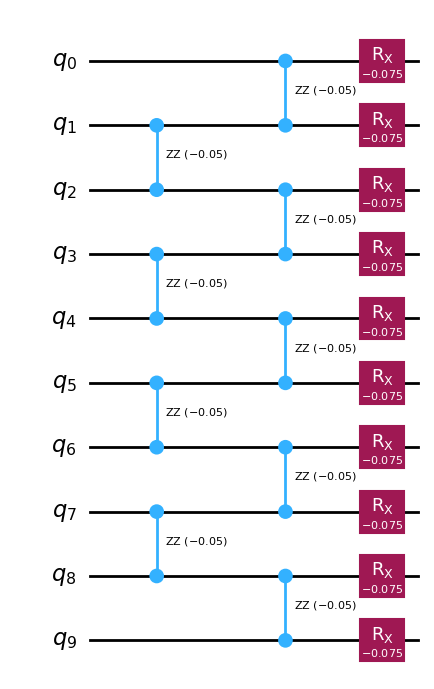

In [19]:
Evolve_Basic = evolve_basic(x, dt, N)
Evolve_Basic.draw('mpl', filename = 'evolve_basic.png')

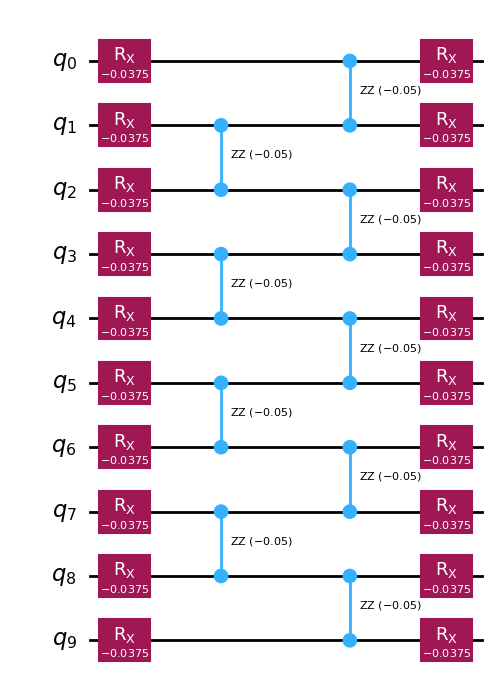

In [20]:
Evolve_Sym = evolve_symmetric(x, dt, N)
Evolve_Sym.draw('mpl', filename = 'evolve_sym.png')

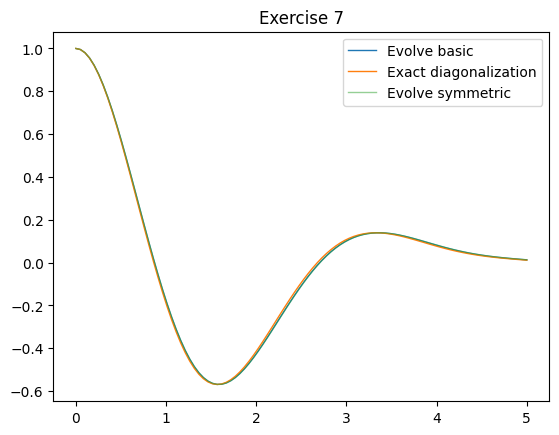

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
time = np.linspace(0, 5, array_size)
plt.plot(time, mt_smooth, label = 'Evolve basic', linewidth = 1)
plt.plot(time, test, label = 'Exact diagonalization', linewidth = 1)
plt.plot(time, mt_smooth_1, label = 'Evolve symmetric', linewidth = 1, alpha = 0.5)
plt.legend()
plt.title('Exercise 7')
plt.savefig('ex_7.png', dpi = 300)

<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:9: SyntaxWarning: invalid escape sequence '\l'
<>:10: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:12: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:9: SyntaxWarning: invalid escape sequence '\l'
<>:10: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:12: SyntaxWarning: invalid escape sequence '\l'
/var/folders/lj/rrwpcg_53lx6mcxdcppxsdz80000gn/T/ipykernel_38209/1805749832.py:4: SyntaxWarnin

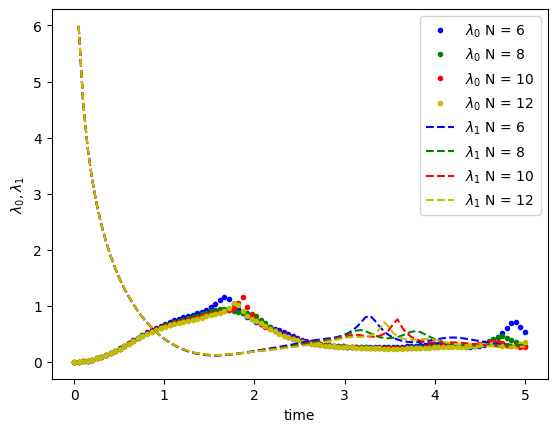

In [22]:
N = [6, 8, 10, 12]

plt.xlabel('time')
plt.ylabel('$ \lambda_0, \lambda_1 $')
plt.plot(time, lambd_smooth[0,:,0], 'b.', label = '$ \lambda_0 $ N = 6')
plt.plot(time, lambd_smooth[1,:,0], 'g.', label = '$ \lambda_0 $ N = 8 ')
plt.plot(time, lambd_smooth[2,:,0], 'r.', label = '$ \lambda_0 $ N = 10 ')
plt.plot(time, lambd_smooth[3,:,0], 'y.', label = '$ \lambda_0 $ N = 12 ')
plt.plot(time, lambd_smooth[0,:,1], 'b--', label = '$ \lambda_1 $ N = 6 ')
plt.plot(time, lambd_smooth[1,:,1], 'g--', label = '$ \lambda_1 $ N = 8 ')
plt.plot(time, lambd_smooth[2,:,1], 'r--', label = '$ \lambda_1 $ N = 10 ')
plt.plot(time, lambd_smooth[3,:,1], 'y--', label = '$ \lambda_1 $ N = 12 ')

plt.legend()
plt.title('')
plt.savefig('lambda01_qubit_basic.png', dpi = 300)

<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:9: SyntaxWarning: invalid escape sequence '\l'
<>:10: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:9: SyntaxWarning: invalid escape sequence '\l'
<>:10: SyntaxWarning: invalid escape sequence '\l'
/var/folders/lj/rrwpcg_53lx6mcxdcppxsdz80000gn/T/ipykernel_38209/564178195.py:2: SyntaxWarning: in

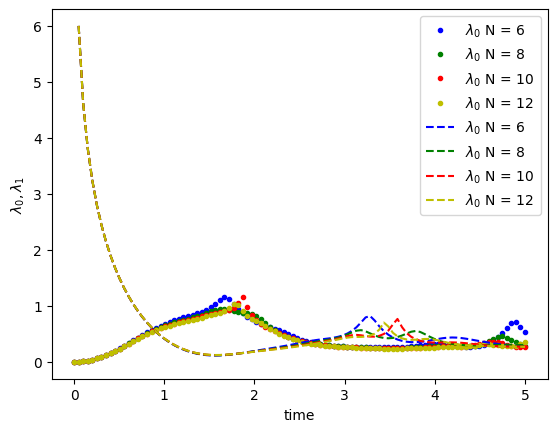

In [23]:

plt.xlabel('time')
plt.ylabel('$ \lambda_0, \lambda_1 $')
plt.plot(time, lambd_smooth_sym[0,:,0], 'b.', label = '$ \lambda_0 $ N = 6')
plt.plot(time, lambd_smooth_sym[1,:,0], 'g.', label = '$ \lambda_0 $ N = 8 ')
plt.plot(time, lambd_smooth_sym[2,:,0], 'r.', label = '$ \lambda_0 $ N = 10 ')
plt.plot(time, lambd_smooth_sym[3,:,0], 'y.', label = '$ \lambda_0 $ N = 12 ')
plt.plot(time, lambd_smooth_sym[0,:,1], 'b--', label = '$ \lambda_0 $ N = 6 ')
plt.plot(time, lambd_smooth_sym[1,:,1], 'g--', label = '$ \lambda_0 $ N = 8 ')
plt.plot(time, lambd_smooth_sym[2,:,1], 'r--', label = '$ \lambda_0 $ N = 10 ')
plt.plot(time, lambd_smooth_sym[3,:,1], 'y--', label = '$ \lambda_0 $ N = 12 ')

plt.legend()
plt.title('')
plt.savefig('lambda01_qubit_sym.png', dpi = 300)

<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
/var/folders/lj/rrwpcg_53lx6mcxdcppxsdz80000gn/T/ipykernel_38209/848955731.py:2: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$ \lambda $')


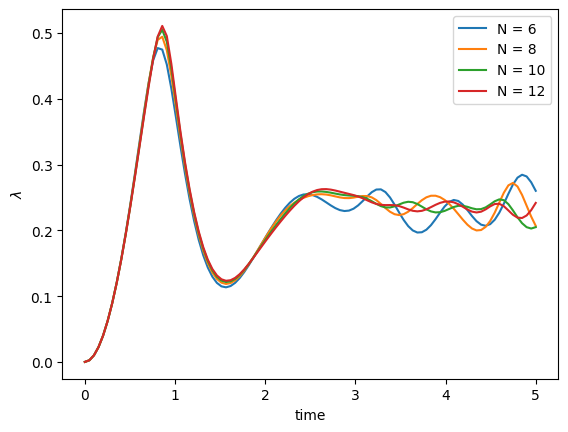

In [24]:
plt.xlabel('time')
plt.ylabel('$ \lambda $')
for i in range(4):
    plt.plot(time, lambd_smooth[i,:,2], label = f'N = {N[i]}')
    plt.legend()
    plt.title('')
plt.savefig('lambda_qubit_basic.png', dpi = 300)

<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
/var/folders/lj/rrwpcg_53lx6mcxdcppxsdz80000gn/T/ipykernel_38209/1138886075.py:2: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$ \lambda $')


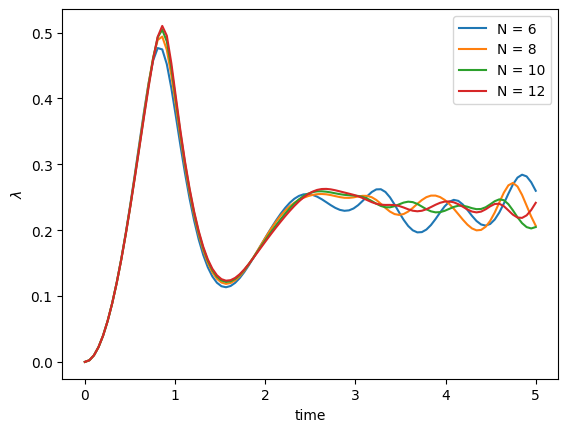

In [25]:
plt.xlabel('time')
plt.ylabel('$ \lambda $')
for i in range(4):
    plt.plot(time, lambd_smooth_sym[i,:,2], label = f'N = {N[i]}')
    plt.legend()
    plt.title('')
plt.savefig('lambda_qubit_sym.png', dpi = 300)

<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
/var/folders/lj/rrwpcg_53lx6mcxdcppxsdz80000gn/T/ipykernel_38209/3508752082.py:3: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$ \lambda_0, \lambda_1 $')


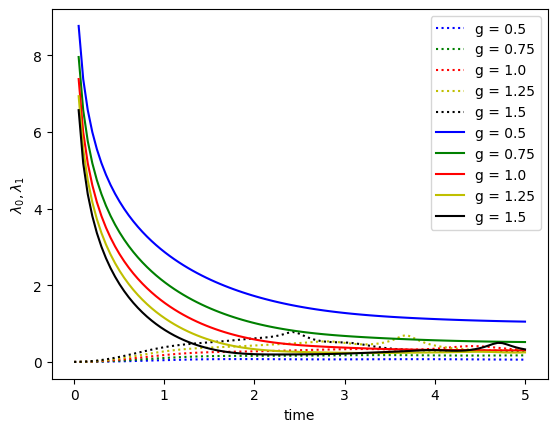

In [26]:
g = np.linspace(0.5, 1.5, 5)
plt.xlabel('time')
plt.ylabel('$ \lambda_0, \lambda_1 $')
plt.plot(time, lambd_smooth_1[0,:,0], 'b:', label = f'g = {round(g[0],2)}')
plt.plot(time, lambd_smooth_1[1,:,0], 'g:', label = f'g = {round(g[1],2)}')
plt.plot(time, lambd_smooth_1[2,:,0], 'r:', label = f'g = {round(g[2],2)}')
plt.plot(time, lambd_smooth_1[3,:,0], 'y:', label = f'g = {round(g[3],2)}')
plt.plot(time, lambd_smooth_1[4,:,0], 'k:', label = f'g = {round(g[4],2)}')
#plt.plot(time, lambd_smooth_1[4,:,0], 'm:', label = f'g = {round(g[5],2)}')
plt.plot(time, lambd_smooth_1[0,:,1], 'b-', label = f'g = {round(g[0],2)}')
plt.plot(time, lambd_smooth_1[1,:,1], 'g-', label = f'g = {round(g[1],2)}')
plt.plot(time, lambd_smooth_1[2,:,1], 'r-', label = f'g = {round(g[2],2)}')
plt.plot(time, lambd_smooth_1[3,:,1], 'y-', label = f'g = {round(g[3],2)}')
plt.plot(time, lambd_smooth_1[4,:,1], 'k-', label = f'g = {round(g[4],2)}')
#plt.plot(time, lambd_smooth_1[4,:,1], 'm-', label = f'g = {round(g[5],2)}')

plt.legend()
plt.title('')
plt.savefig('lambda01_g_basic.png', dpi = 300)

In [27]:
g = np.linspace(0.5, 1.5, 5)


#plt.plot(time, lambd_smooth_1[6,:,0], 'g:', label = f'g = {round(g[6],2)}')
#plt.plot(time, lambd_smooth_1[7,:,0], 'r:', label = f'g = {round(g[7],2)}')
#plt.plot(time, lambd_smooth_1[8,:,0], 'y:', label = f'g = {round(g[8],2)}')
#plt.plot(time, lambd_smooth_1[9,:,0], 'k:', label = f'g = {round(g[9],2)}')

#plt.plot(time, lambd_smooth_1[6,:,1], 'b-', label = f'g = {round(g[6],2)}')
#plt.plot(time, lambd_smooth_1[7,:,1], 'g-', label = f'g = {round(g[7],2)}')
#plt.plot(time, lambd_smooth_1[8,:,1], 'r-', label = f'g = {round(g[8],2)}')
#plt.plot(time, lambd_smooth_1[9,:,1], 'y-', label = f'g = {round(g[9],2)}')

#plt.legend()
#plt.title('Lambda_0 Lambda_1 for different g')
#plt.savefig('lambda01_g_basic_DPQT.png', dpi = 300)

<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
/var/folders/lj/rrwpcg_53lx6mcxdcppxsdz80000gn/T/ipykernel_38209/191306302.py:2: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$ \lambda_0, \lambda_1 $')


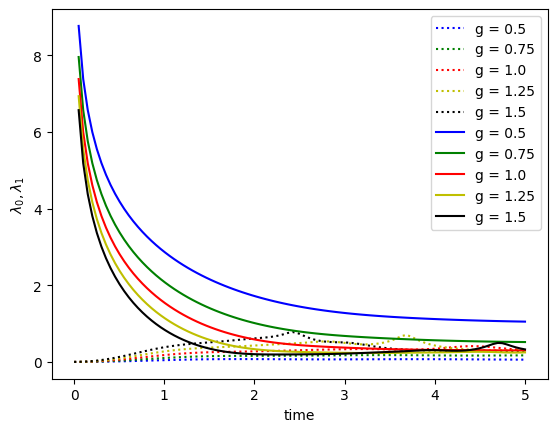

In [28]:
plt.xlabel('time')
plt.ylabel('$ \lambda_0, \lambda_1 $')
plt.plot(time, lambd_smooth_sym_1[0,:,0], 'b:', label = f'g = {round(g[0],2)}')
plt.plot(time, lambd_smooth_sym_1[1,:,0], 'g:', label = f'g = {round(g[1],2)}')
plt.plot(time, lambd_smooth_sym_1[2,:,0], 'r:', label = f'g = {round(g[2],2)}')
plt.plot(time, lambd_smooth_sym_1[3,:,0], 'y:', label = f'g = {round(g[3],2)}')
plt.plot(time, lambd_smooth_sym_1[4,:,0], 'k:', label = f'g = {round(g[4],2)}')
#plt.plot(time, lambd_smooth_sym_1[4,:,0], 'm:', label = f'g = {round(g[5],2)}')
plt.plot(time, lambd_smooth_sym_1[0,:,1], 'b-', label = f'g = {round(g[0],2)}')
plt.plot(time, lambd_smooth_sym_1[1,:,1], 'g-', label = f'g = {round(g[1],2)}')
plt.plot(time, lambd_smooth_sym_1[2,:,1], 'r-', label = f'g = {round(g[2],2)}')
plt.plot(time, lambd_smooth_sym_1[3,:,1], 'y-', label = f'g = {round(g[3],2)}')
plt.plot(time, lambd_smooth_sym_1[4,:,1], 'k-', label = f'g = {round(g[4],2)}')
#plt.plot(time, lambd_smooth_sym_1[4,:,1], 'm-', label = f'g = {round(g[5],2)}')

plt.legend()
plt.title('')
plt.savefig('lambda01_g_sym.png', dpi = 300)

<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
/var/folders/lj/rrwpcg_53lx6mcxdcppxsdz80000gn/T/ipykernel_38209/328883382.py:2: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$ \lambda $')


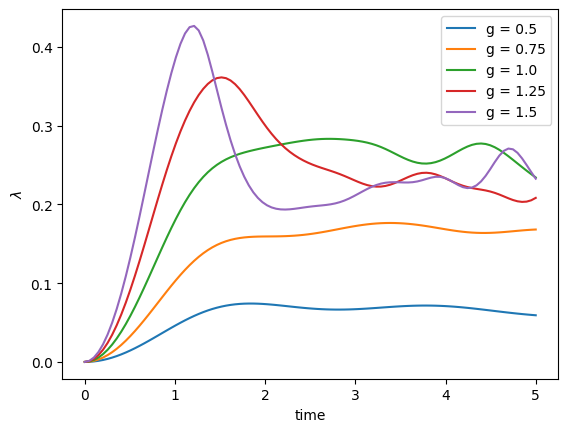

In [29]:
plt.xlabel('time')
plt.ylabel('$ \lambda $')
for i in range(5):
    plt.plot(time, lambd_smooth_1[i,:,2], label = f'g = {round(g[i],2)}')
    plt.legend()
    plt.title('')
plt.savefig('lambda_g_basic.png', dpi = 300)

<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
/var/folders/lj/rrwpcg_53lx6mcxdcppxsdz80000gn/T/ipykernel_38209/3824067682.py:2: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$ \lambda $')


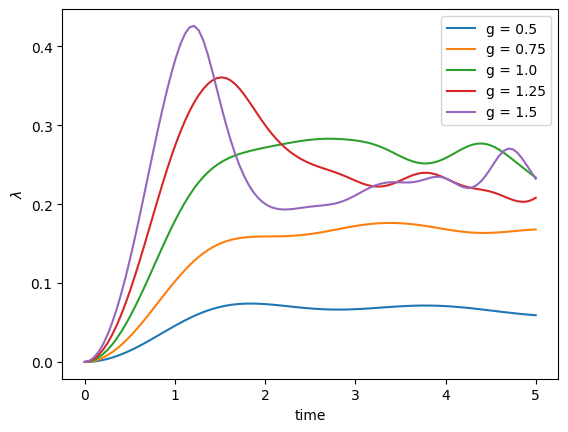

In [30]:
plt.xlabel('time')
plt.ylabel('$ \lambda $')
for i in range(5):
    plt.plot(time, lambd_smooth_sym_1[i,:,2], label = f'g = {round(g[i],2)}')
    plt.legend()
    plt.title('')
plt.savefig('lambda_g_sym.png', dpi = 300)

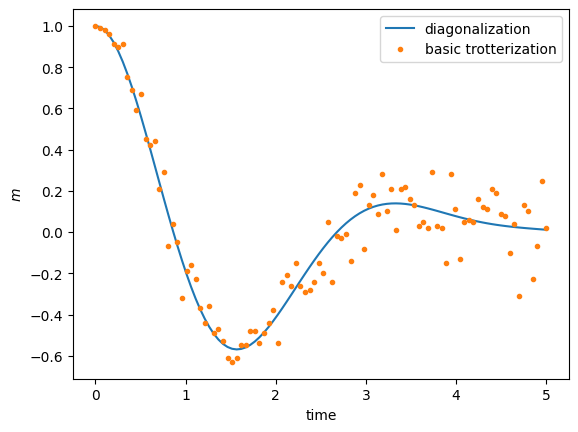

In [31]:
#plt.plot(time, mt2, label = 'symmetric trotterization')
plt.xlabel('time')
plt.ylabel('$ m $')
plt.plot(time,test, label = 'diagonalization')
plt.plot(time, mt,'.', label = 'basic trotterization')
plt.legend()
plt.title('')
plt.title('')
plt.savefig('ex9.png', dpi = 300)

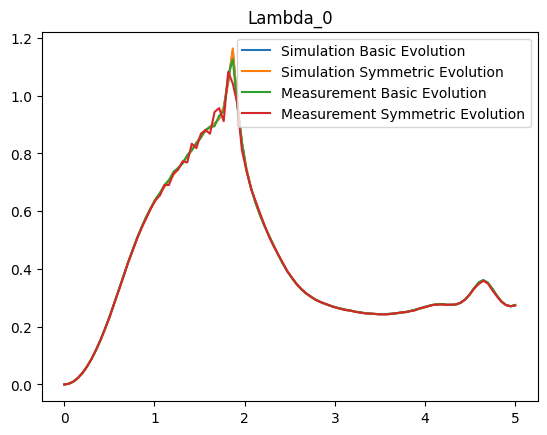

In [32]:
plt.plot(time, lambd_smooth[2,:,0], label = f'Simulation Basic Evolution')
plt.plot(time, lambd_smooth_sym[2,:,0], label = f'Simulation Symmetric Evolution')
plt.plot(time, lambd_ex9[:,0], label = f'Measurement Basic Evolution')
plt.plot(time, lambd_ex9_1[:,0], label = f'Measurement Symmetric Evolution')
plt.legend()
plt.title('Lambda_0')
plt.savefig('lambda0_ex9.png', dpi = 300)

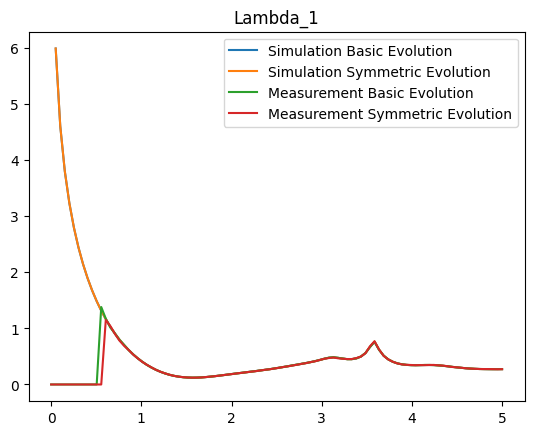

In [33]:
plt.plot(time, lambd_smooth[2,:,1], label = f'Simulation Basic Evolution')
plt.plot(time, lambd_smooth_sym[2,:,1], label = f'Simulation Symmetric Evolution')
plt.plot(time, lambd_ex9[:,1], label = f'Measurement Basic Evolution')
plt.plot(time, lambd_ex9_1[:,1], label = f'Measurement Symmetric Evolution')
plt.legend()
plt.title('Lambda_1')
plt.savefig('lambda1_ex1.png', dpi = 300)

<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
/var/folders/lj/rrwpcg_53lx6mcxdcppxsdz80000gn/T/ipykernel_38209/871129093.py:2: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$ \lambda $')


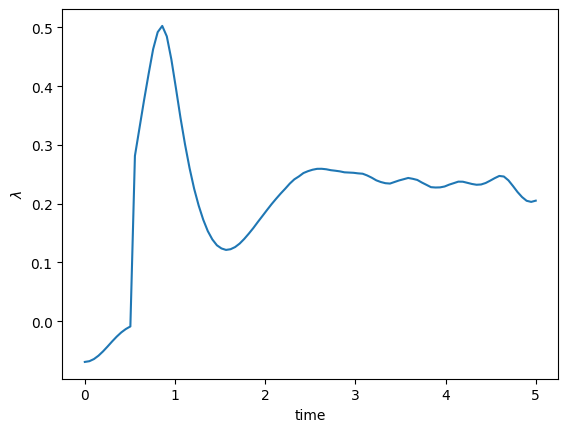

In [51]:
plt.xlabel('time')
plt.ylabel('$ \lambda $')
plt.plot(time, lambd_ex9[:,2])
plt.savefig('lambda_ex9.png', dpi = 300)

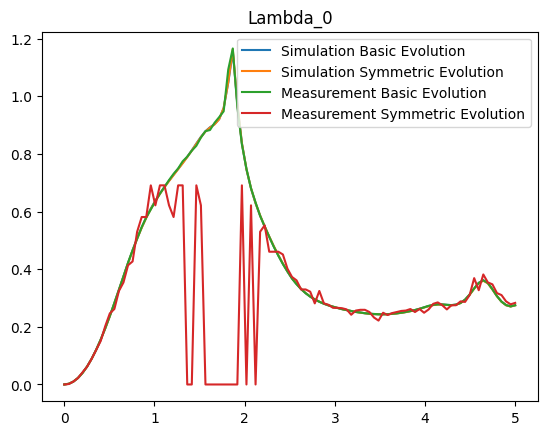

In [35]:
plt.plot(time, lambd_smooth[2,:,0], label = f'Simulation Basic Evolution')
plt.plot(time, lambd_smooth_sym[2,:,0], label = f'Simulation Symmetric Evolution')
plt.plot(time, lambd_ex9_20[:,0], label = f'Measurement Basic Evolution')
plt.plot(time, lambd_ex9_1_20[:,0], label = f'Measurement Symmetric Evolution')
plt.legend()
plt.title('Lambda_0')
plt.savefig('lambda0_ex9_20.png', dpi = 300)

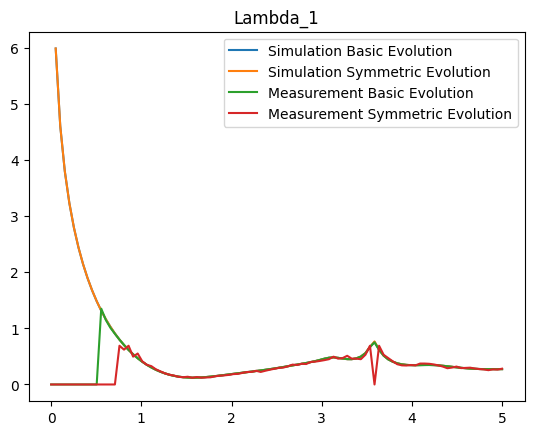

In [36]:
plt.plot(time, lambd_smooth[2,:,1], label = f'Simulation Basic Evolution')
plt.plot(time, lambd_smooth_sym[2,:,1], label = f'Simulation Symmetric Evolution')
plt.plot(time, lambd_ex9_20[:,1], label = f'Measurement Basic Evolution')
plt.plot(time, lambd_ex9_1_20[:,1], label = f'Measurement Symmetric Evolution')
plt.legend()
plt.title('Lambda_1')
plt.savefig('lambda1_ex9_20.png', dpi = 300)

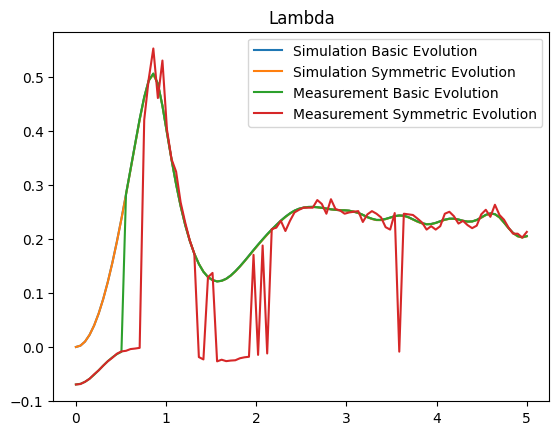

In [37]:
plt.plot(time, lambd_smooth[2,:,2], label = f'Simulation Basic Evolution')
plt.plot(time, lambd_smooth_sym[2,:,2], label = f'Simulation Symmetric Evolution')
plt.plot(time, lambd_ex9_20[:,2], label = f'Measurement Basic Evolution')
plt.plot(time, lambd_ex9_1_20[:,2], label = f'Measurement Symmetric Evolution')
plt.legend()
plt.title('Lambda')
plt.savefig('lambda_ex9_20.png', dpi = 300)

<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
/var/folders/lj/rrwpcg_53lx6mcxdcppxsdz80000gn/T/ipykernel_38209/2497224828.py:2: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$ \lambda, m $')
/var/folders/lj/rrwpcg_53lx6mcxdcppxsdz80000gn/T/ipykernel_38209/2497224828.py:6: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(time, lambd_smooth[2,:,2], label = f'$ \lambda $')


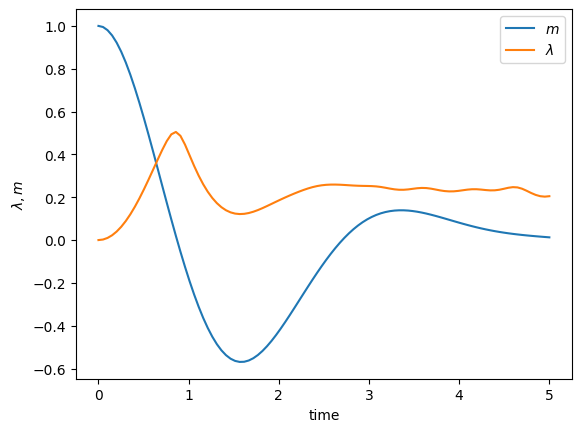

In [38]:
plt.xlabel('time')
plt.ylabel('$ \lambda, m $')
plt.plot(time, mt_smooth, label = f'$m$')
#plt.plot(time, lambd_smooth[2,:,0], label = f'Lambda_0')
#plt.plot(time, lambd_smooth[2,:,1], label = f'Lambda_1')
plt.plot(time, lambd_smooth[2,:,2], label = f'$ \lambda $')
plt.legend()
plt.title('')

plt.savefig('mag_lambd.png', dpi = 300)